# 데이터 획득

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# 모듈
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score, recall_score, precision_score, f1_score, classification_report, roc_curve
from scipy import sparse
import xgboost as xgb
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

%matplotlib inline

In [ ]:
# 데이터 가져오기 
data_path = '/content/drive/MyDrive/모듈프젝2/B팀-분류/data/playground-series-season-3-episode-2/'

train = pd.read_csv(data_path + 'train.csv', index_col='id')
test = pd.read_csv(data_path + 'test.csv', index_col='id')
submission = pd.read_csv(data_path + 'sample_submission.csv', index_col='id')
# 원본 데이터 
original = pd.read_csv(data_path + 'healthcare-dataset-stroke-data.csv', index_col='id')

# 데이터 준비 + EDA(분석, 피처 엔지니어링 대상 및 처리내용 체크)

In [ ]:
train.head().T

id,0,1,2,3,4
gender,Male,Male,Female,Male,Female
age,28.0,33.0,42.0,56.0,24.0
hypertension,0,0,0,0,0
heart_disease,0,0,0,0,0
ever_married,Yes,Yes,Yes,Yes,No
work_type,Private,Private,Private,Private,Private
Residence_type,Urban,Rural,Rural,Urban,Rural
avg_glucose_level,79.53,78.44,103.0,64.87,73.36
bmi,31.1,23.9,40.3,28.8,28.8
smoking_status,never smoked,formerly smoked,Unknown,never smoked,never smoked


- 데이터 확인 내용




```

'gender', : Male, Female, other로 구성됨 
            - other의 개수 1개로 확인됨
'age', : 나이 /  수치형
'hypertension',  : 고혈압 유무 / 0 : 무, 1 : 유 => 이진형
'heart_disease', : 심장질환 유무 / 0 : 무, 1 : 유 => 이진형
'ever_married', : 결혼 유무 / Y : 기혼, N : 미혼 => 이진형
'work_type', : 업무형태 / 'Private', 'children', 'Govt_job', 'Self-employed', 'Never_worked' => 명목형
'Residence_type', : 거주지 /  Urban, Rural / 도시, 시골 => 이진형
'avg_glucose_level', 평균 당 수치 / 수치형 
'bmi', : 비만도 / 수치형
'smoking_status', : 흡연상태  / 'never smoked', 'formerly smoked', 'Unknown', 'smokes' => 명목형
'stroke' : 뇌졸중 유무 / 0 : 무, 1 : 유  => 정답
```

In [ ]:
# 고유값 갯수 확인
train.nunique().values, test.nunique().values, submission.nunique().values

(array([   3,  106,    2,    2,    2,    5,    2, 3740,  407,    4,    2]),
 array([   3,  106,    2,    2,    2,    5,    2, 3265,  400,    4]),
 array([1]))

In [ ]:
# train, test, submission 컬럼 확인
train.columns, test.columns, submission.columns

(Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status', 'stroke'],
       dtype='object'),
 Index(['gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
        'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
        'smoking_status'],
       dtype='object'),
 Index(['stroke'], dtype='object'))

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15304 entries, 0 to 15303
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15304 non-null  object 
 1   age                15304 non-null  float64
 2   hypertension       15304 non-null  int64  
 3   heart_disease      15304 non-null  int64  
 4   ever_married       15304 non-null  object 
 5   work_type          15304 non-null  object 
 6   Residence_type     15304 non-null  object 
 7   avg_glucose_level  15304 non-null  float64
 8   bmi                15304 non-null  float64
 9   smoking_status     15304 non-null  object 
 10  stroke             15304 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


In [ ]:
original.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5110 entries, 9046 to 44679
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   Residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 479.1+ KB


In [ ]:
# 결측치 확인 - original 결측값 확인됨
train.isnull().sum().values, test.isnull().sum().values,submission.isnull().sum().values, original.isnull().sum().values

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0]),
 array([  0,   0,   0,   0,   0,   0,   0,   0, 201,   0,   0]))

In [ ]:
# bmi 항목 결측치 확인 => 결측치 해결 검토 
original.isna().sum()

gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [ ]:
# test.id = submission id 
train.shape, test.shape, submission.shape

((15304, 11), (10204, 10), (10204, 1))

- test, submission의 id 동일함
- 정답인 stroke는 test 데이터에는 없음 / train, submission에만 존재함
- original파일의 bmi 항목 결측값 확인됨

## 시각화를 통한 정답값 분포 확인

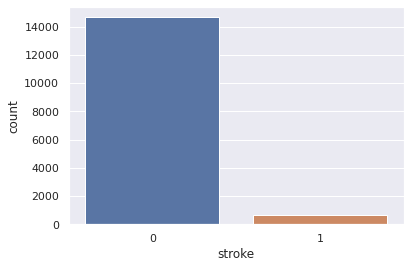

In [ ]:
# stroke 값 확인
# 뇌졸중을 가진 사람보다 뇌졸중이 아닌 사람이 많음 
sns.countplot(data=train, x='stroke');

In [ ]:
c0, c1 = np.unique( train.stroke.values, return_counts=True)[1]
c0 / c1 
# 0이 1보다 23.21518987341772배 많음 => 뇌졸중 환자보다 뇌졸중 환자가 아닌 사람이 23.21518987341772배 많음

23.21518987341772

타겟값간 비율 23.21518987341772


Text(0.5, 1.0, 'Stroke Value Distribution')

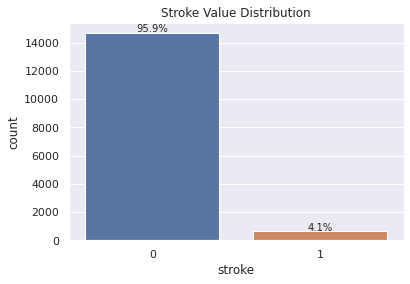

In [ ]:
# 향후 시각화 자료에 비율을 표기하는 부분을 추가 => 텍스트 드로잉
def show_text_percent_by_stroke( ax, total_count, is_show=True,  ):
  '''
    is_show : True일때만 텍스트가 노출되게 처리
    ax : 텍스트를 그리고자 하는 차트의 축정보
    total_count : 전체 카운트수
  '''
  persents = list()         # 비율을 담는 그릇
  # 카운트 플롯 차트상에 개별 박스 정보를 구하는 방법 -> ax.patches

  # 카운트 플롯 차트상에서 순차적으로 박스를 하나씩 추출한다
  for patch in ax.patches: # 차트상에 존재하는 모든 형태의 도형을 차례대로 추출하는 연속형 변수
    w = patch.get_width()  # 타겟값 0 혹은 1, 카운트 플롯의 개별 박스 너비
    h = patch.get_height() # 타겟값 0 혹은 1의 카운트수 -> 카운트 플롯의 개별 박스 높이->카운트
    p = h/total_count * 100 # 타깃값의 비율 = (개별박스의 높이(카운트) / 전체카운트)*100
    persents.append( p )
    # 텍스트 그리기
    # 좌표 정보 획득
    l = patch.get_x()    # 도형 왼쪽 테투리 X축의 기준 위치값    
    ax.text(  x=l + w/2,  # 도형의 정 가운데를 X축 좌표
              y=h + total_count*0.005, # 1, total_count(가변값)의 특정 비율로 올려서 위치를 조정
              s=f'{p:1.1f}%', # 타겟값의 비율을 개별 차트내 도형 위에 그려지는 내용 ex) 38.8% /  현 차트 내에 69.4%, 30.6% 임
              ha='center'    # 정렬(가운데)
            )
  if is_show:
    if len(persents) == 2: # 타겟용
      print( '타겟값간 비율', persents[0]/persents[1] )
    elif len(persents) == 4: # 이진 피처용
      # print(persents)
      # 타겟값에 맞춰서 도형이 그려진다 0번 타겟이 먼저 그려지고, 1번 타겟이 나중에 그려진다
      print( persents[0]/persents[2], persents[1]/persents[3] )
  pass

ax = sns.countplot( data=train, x='stroke');
show_text_percent_by_stroke( ax, train.shape[0] )
ax.set_title('Stroke Value Distribution')

- 정답 값 중 0(뇌졸중 무) : 95.9% 를 차지하고 있음
- 정답 값 중 0(뇌졸중 유) : 4.1% 를 차지하고 있음

##데이터 분석

- 수치형
  - age
  - avg_glucose_level
  -bmi
- 명목형
  - 이진형
    - hypertension
    - heart_disease
    - Residence_type
    - ever_married
  - 고유값 2개 초과
    - gender
    - work_type
    - smoking_status

In [ ]:
# 수치형
num_cols = ['age', 'avg_glucose_level', 'bmi'] 
# 명목형
cat_cols = ['gender', 'hypertension','heart_disease', 'Residence_type', 'work_type', 'smoking_status'] 
# 명목형을 고유값 개수에 따라 세부 분류함
cat_cols_v0 = ['gender'] # gender만 따로 진행한 이유는 male, female, other로 고유값 3개로 확인되어 따로 지정해둠 
cat_cols_v1 = ['hypertension','heart_disease', 'Residence_type', 'ever_married'] # 이진형
cat_cols_v2 = ['work_type', 'smoking_status'] # 명목형

### 수치형

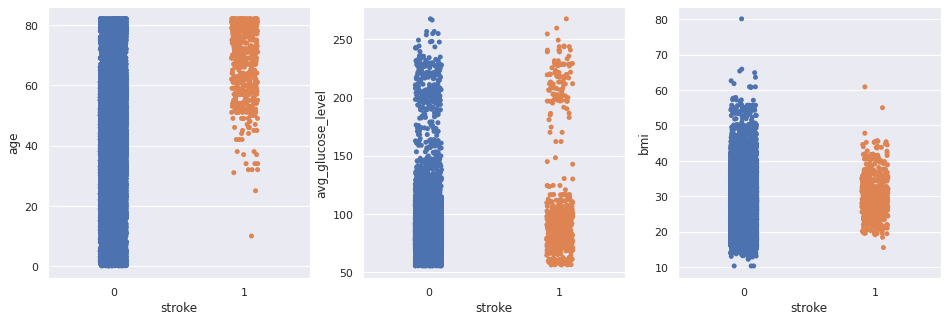

In [ ]:
# 수치형 데이터 시각화 
plt.figure(figsize=(16, 5))
plt.subplot(1, 3,1)
sns.stripplot(data=train, x='stroke', y='age' )
plt.subplot(1, 3,2)
sns.stripplot(data=train, x='stroke', y='avg_glucose_level')
plt.subplot(1, 3,3)
sns.stripplot(data=train, x='stroke', y='bmi')

- 나이 :뇌졸중 환자 중  40~60대 많음
- 평균 당수치 : 뇌졸중 환자 중 당 수치가 높은 사람보다 낮은 사람이 많다 => 당수치와의 상관관계는 적은 것으로 예상됨
- bmi : 뇌졸중 환자의 bmi 수치는 약 20 ~ 40에 분포되어 있으나 뇌졸중 환자가 아닌 사람 또한 비슷한 구간에 분표되어 있어 변별력은 없을 것이라고 예상됨

### 명목형

- 이진형
  - hypertension
  - heart_disease
  - Residence_type
  - ever_married
- 고유값 2개 초과
  - gender
  - work_type
  - smoking_status

### 고유값 2개 이상

In [ ]:
train['gender'].unique()
# 'Male', 'Female', 'Other' 존재함

array(['Male', 'Female', 'Other'], dtype=object)

In [ ]:
train['gender'].value_counts()
# 'other'이 1개 존재함

Female    9446
Male      5857
Other        1
Name: gender, dtype: int64

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


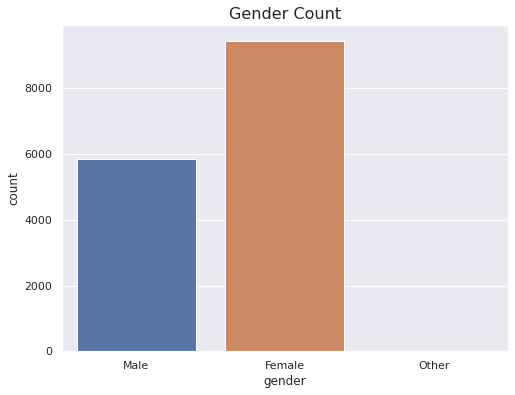

In [ ]:
# gender의 개수 시각화 
# 데이터 중 남성보다 여성이 높다 
plt.figure(figsize=(8, 6))

ax = sns.countplot(train['gender'])
ax.set_title('Gender Count', fontdict={'fontsize': 16})
plt.show()

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


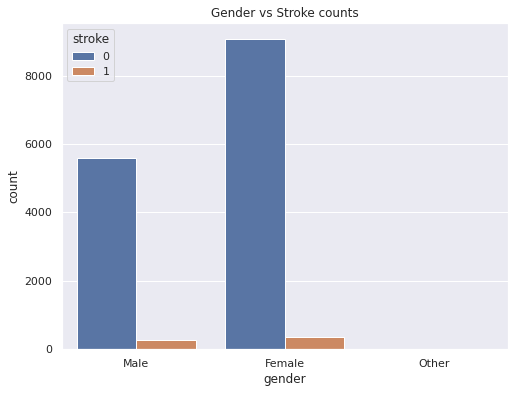

In [ ]:
# gender별 뇌졸중 유무 시각화 
plt.figure(figsize=(8, 6))
ax = sns.countplot(train['gender'], hue=train['stroke'])
ax.set_title('Gender vs Stroke counts')
plt.show()

In [ ]:
# gender 교차분석표 작성
def make_cross_tab(df, id ):
  cross_tab = pd.crosstab( df[id], df['stroke'], normalize='index' ) *100
  cross_tab.reset_index(inplace=True)
  return cross_tab

cross_tab_v1 = make_cross_tab(train, 'gender') 
cross_tab_v1

stroke,gender,0,1
0,Female,96.104171,3.895829
1,Male,95.492573,4.507427
2,Other,100.000000,0.000000


- Female 중 약 3.89%, Male 중 약 4.50%가 뇌졸중 환자로 확인됨
- other은 1명 존재하며 뇌졸중 환자가 아님

In [ ]:
# work_type 고유값 확인
train['work_type'].unique()

array(['Private', 'Self-employed', 'Govt_job', 'children', 'Never_worked'],
      dtype=object)

In [ ]:
# work_type 고유값별 개수 확인
train['work_type'].value_counts()

Private          9752
children         2038
Self-employed    1939
Govt_job         1533
Never_worked       42
Name: work_type, dtype: int64

In [ ]:
# work_type 교차분석표
cross_tab_v2 = make_cross_tab(train, 'work_type') 
cross_tab_v2

stroke,work_type,0,1
0,Govt_job,95.499022,4.500978
1,Never_worked,100.000000,0.000000
2,Private,95.857260,4.142740
3,Self-employed,91.851470,8.148530
4,children,99.950932,0.049068


In [ ]:
# smoking_status 고유값 확인
train['smoking_status'].unique()

array(['never smoked', 'formerly smoked', 'Unknown', 'smokes'],
      dtype=object)

In [ ]:
# smoking_status 고유값별 개수 확인
train['smoking_status'].value_counts()

never smoked       6281
Unknown            4543
formerly smoked    2337
smokes             2143
Name: smoking_status, dtype: int64

In [ ]:
# smoking_status 교차분석표
cross_tab_v3 = make_cross_tab(train, 'smoking_status') 
cross_tab_v3

stroke,smoking_status,0,1
0,Unknown,97.622716,2.377284
1,formerly smoked,93.196406,6.803594
2,never smoked,95.908295,4.091705
3,smokes,94.960336,5.039664


In [ ]:
# cat_cols_v2 = ['work_type', 'smoking_status']
def show_pointplot(id,cross_tab, color, ax=None):
  if ax:
    sns.pointplot( x= id ,            # 피처값
                  y= 1,            # 정답 1에 대한 포인트 플롯
                  data=cross_tab,  # 그리는 대상 df 
                  order= cross_tab[id],          # 포인트 플롯 순서 
                  color=color,     # 그리는 색상
                  ax=ax
                  );
show_pointplot_v2 = show_pointplot('work_type', cross_tab_v2, 'blue')
show_pointplot_v3 = show_pointplot('smoking_status', cross_tab_v2, 'blue')
# nom_0에 설정된 사용하는 고유값 별로 1의 비율이 다르다 -> 구분된다 -> 학습에 도움된다 

0.723292469352014 1.0905272981801213


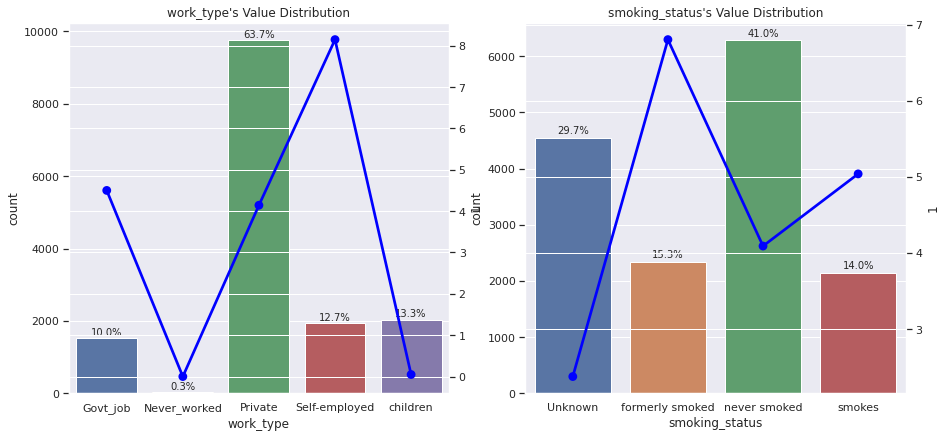

In [ ]:
# cat_cols_v2 = ['work_type', 'smoking_status']
def show_count_point_plot( all_data, features, rows=2, cols=2): 
  # 1개의 차트에 격자로 분할 -> 각 자리에 ax를 전달 -> 이것을 이용하여 그린다 
  plt.figure( figsize=(15,15) ) # 그리면서 조정 : 세로 3칸, 가로 2칸
  # 서브플롯 배치 
  p_grid = gridspec.GridSpec(rows, cols) # 3줄, 2칸 => 차트 5개 ;=> 피처가 5개

  for idx, feature in enumerate( features ):
    ax = plt.subplot(p_grid[idx])
    cross_tab = make_cross_tab(all_data, feature )
      # order를 사용했으면 한 차트에 사용되는 모든 함수는 같은 순서(order) 유지해야 동일하게 배치됨(그렇지 않으면 배치가 달라질 수 있다)
    sns.countplot( data=all_data, x=feature, ax=ax, order=cross_tab[feature] ) # ax=ax : 격자 안에서 특정 위치로 차트가 세팅
    show_text_percent_by_stroke( ax, all_data.shape[0] )
    ax.set_title(f'{feature}\'s Value Distribution')

    
    show_pointplot(feature, cross_tab, 'blue', ax.twinx())

  plt.show()

show_count_point_plot( train, cat_cols_v2)

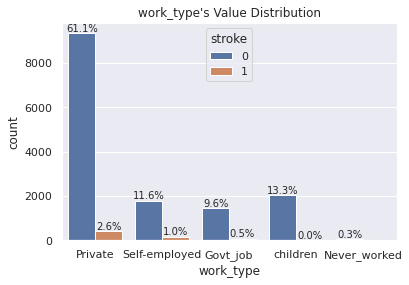

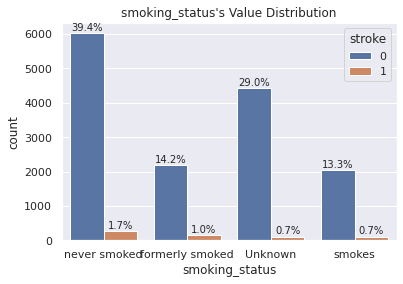

In [ ]:
cat_cols_v2 = ['work_type', 'smoking_status']
for cat_col_v2 in cat_cols_v2:
  ax = sns.countplot( data=train, x=cat_col_v2, hue='stroke');
  show_text_percent_by_stroke( ax, train.shape[0] )
  ax.set_title(f'{cat_col_v2}\'s Value Distribution')
  plt.show()

- 업무 : 업무에 따른 발병 순위는 Self-employed - Govt_job - Private_work_type - children - Never_worked
- 흡연 : 흡연에 따른 발병 순위는 fermerly smoked - smokes - never smoked - Unknown

### 이진형

27.855158730158724 4.945312500000001


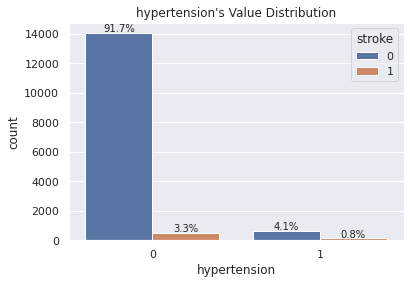

25.40812720848057 4.409090909090908


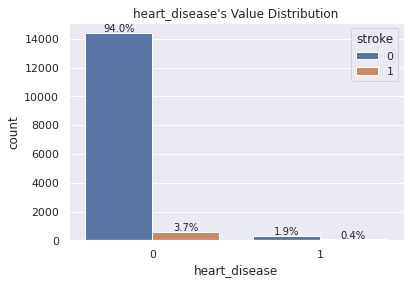

23.253968253968253 23.176656151419557


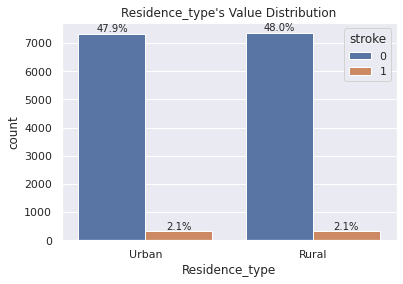

16.57191201353638 118.97560975609757


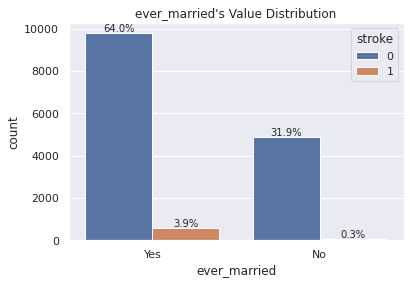

In [ ]:
# 이진형 데이터별 
for cat_col_v1 in cat_cols_v1:
  ax = sns.countplot( data=train, x=cat_col_v1, hue='stroke');
  show_text_percent_by_stroke( ax, train.shape[0] )
  ax.set_title(f'{cat_col_v1}\'s Value Distribution')
  plt.show()
  
# 고혈압 : 뇌졸중 환자 중 고혈압 환자의 비율은 낮음 
# 심장질환 : 뇌졸중 환자 중 심장질환 환자의 비율은 낮음
# 거주지역 : 도시, 시골 비율 거의 동일함 => 해당 부분으로는 변별력이 없을 것이라고 예상됨 
# 결혼 : 결혼한 사람들의 비율이 높으며 뇌졸중 환자 중 기혼의 비율이 높음

- 데이터 중 Residence_type과 bmi의 경우 뇌졸중 환자가 아닌 사람과 뇌졸중 환자인 사람들의 분포가 비슷하게 나와서 해당 데이터로는 상관관계를 분석하기에는 무리가 있다고 판단됨

## 데이터 병합

In [ ]:
original_st =  original[original[['stroke']].all(1)]
train = pd.concat((train, original_st))
train.shape

(15553, 11)

In [ ]:
# 상관관계 분석
train.corr()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
age,1.000000,0.240904,0.202951,0.133673,0.386857,0.299504
hypertension,0.240904,1.000000,0.083803,0.141134,0.108185,0.182415
heart_disease,0.202951,0.083803,1.000000,0.169438,0.057108,0.157579
avg_glucose_level,0.133673,0.141134,0.169438,1.000000,0.119044,0.224479
bmi,0.386857,0.108185,0.057108,0.119044,1.000000,0.076430
stroke,0.299504,0.182415,0.157579,0.224479,0.076430,1.000000


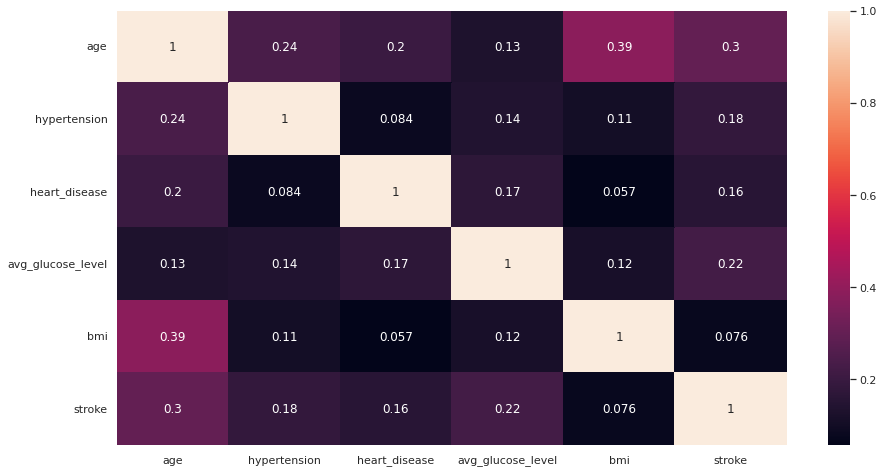

In [ ]:
# 히트맵 -> 모든 피쳐가 약한 양의 상관관계 가짐, 피쳐제거 안함
sns.set(rc = {'figure.figsize':(15,8)})
sns.heatmap(train.corr(), annot=True)

# 결측치 제거
- bmi 컬럼에서 결측이 존재하는 행 제거

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15553 entries, 0 to 43424
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15553 non-null  object 
 1   age                15553 non-null  float64
 2   hypertension       15553 non-null  int64  
 3   heart_disease      15553 non-null  int64  
 4   ever_married       15553 non-null  object 
 5   work_type          15553 non-null  object 
 6   Residence_type     15553 non-null  object 
 7   avg_glucose_level  15553 non-null  float64
 8   bmi                15513 non-null  float64
 9   smoking_status     15553 non-null  object 
 10  stroke             15553 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


In [ ]:
train = train.dropna(subset=['bmi'])

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15513 entries, 0 to 43424
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             15513 non-null  object 
 1   age                15513 non-null  float64
 2   hypertension       15513 non-null  int64  
 3   heart_disease      15513 non-null  int64  
 4   ever_married       15513 non-null  object 
 5   work_type          15513 non-null  object 
 6   Residence_type     15513 non-null  object 
 7   avg_glucose_level  15513 non-null  float64
 8   bmi                15513 non-null  float64
 9   smoking_status     15513 non-null  object 
 10  stroke             15513 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 1.4+ MB


# bmi 제거

In [ ]:
train = train.drop('bmi', axis = 1)
test = test.drop('bmi', axis = 1)

## 인코딩

- gender 
  - gender의 other를 male로 변환
-smoking_status
  - smoking_status의 Unknown을 never_smoked로 변환

In [ ]:
# gender의 other 위치 확인
train[train['gender'].str.contains('Other')]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9363,Other,9.0,0,0,No,children,Rural,96.04,18.0,Unknown,0


In [ ]:
# Other 값을 Male로 변경
train.loc[9363, 'gender'] = 'Male'
test.loc[19933, 'gender'] = 'Male'

In [ ]:
train['gender'].unique() 
# 변경된 것 확인완료

array(['Male', 'Female'], dtype=object)

In [ ]:
test['gender'].unique() 
# 변경된 것 확인완료

array(['Female', 'Male'], dtype=object)

In [ ]:
# smoking_status에 unknown 확인
train[train['smoking_status'].str.contains('Unknown')]

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
2,Female,42.00,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
5,Female,34.00,0,0,Yes,Private,Urban,84.35,22.2,Unknown,0
7,Male,78.00,0,1,Yes,Self-employed,Rural,75.32,24.8,Unknown,0
12,Female,4.00,0,0,No,children,Urban,84.10,14.1,Unknown,0
21,Female,1.72,0,0,No,children,Rural,94.12,20.8,Unknown,0
...,...,...,...,...,...,...,...,...,...,...,...
1210,Female,68.00,0,0,Yes,Private,Rural,211.06,39.3,Unknown,1
28493,Male,57.00,0,0,Yes,Private,Urban,86.30,31.7,Unknown,1
17739,Male,57.00,0,0,Yes,Private,Rural,84.96,36.7,Unknown,1


In [ ]:
# Unknown -> never smoked 변경
train = train.replace({'smoking_status' : 'Unknown'}, 'never smoked')
test = test.replace({'smoking_status' : 'Unknown'}, 'never smoked')

### 인코딩
- 명목형인 gender, ever_married, work_type, Residence_type, smoking_status, hypertension	heart_disease	를 인코딩

In [ ]:
train.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,never smoked,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [ ]:
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 
                        'work_type','Residence_type','smoking_status']

numerical_features = ['age', 'bmi', 'avg_glucose_level']

In [ ]:
from sklearn.compose import ColumnTransformer

ct = ColumnTransformer( 
    [('scaling', StandardScaler(), numerical_features),
    ('onehot', OneHotEncoder(sparse = False), categorical_features)])

# 데이터 나누기

In [ ]:
train_test = pd.concat([train,test], ignore_index=True)
train_test.head(1)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0.0


In [ ]:
train_test.shape

(25717, 11)

In [ ]:
train_test_notstroke = train_test.drop(['stroke'], axis = 1)
train_test_notstroke.head(1)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked


In [ ]:
train_test_notstroke.shape

(25717, 10)

## ColumnTransformer을 이용한 인코딩
- 인코딩할때 타겟값 빼고 하기!!

In [ ]:
ct = ColumnTransformer( 
    [('scaling', StandardScaler(), numerical_features),
    ('onehot', OneHotEncoder(sparse = False), categorical_features)])
ct.fit(train_test_notstroke)
train_test_trans = ct.transform(train_test_notstroke)

In [ ]:
train_test_trans.shape

(25717, 21)

In [ ]:
train_test_trans[0, :]

array([-0.64695675,  0.4335834 , -0.37555979,  0.        ,  1.        ,
        1.        ,  0.        ,  1.        ,  0.        ,  0.        ,
        1.        ,  0.        ,  0.        ,  1.        ,  0.        ,
        0.        ,  0.        ,  1.        ,  0.        ,  1.        ,
        0.        ])

In [ ]:
# # 정답의 결측여부로 해결
# X_sub = train_test_trans[pd.isnull(train_test['stroke'])] # submission용
# # 훈련용 
# X = train_test_trans[~pd.isnull(train_test['stroke'])] 
# X.shape, X_sub.shape

In [ ]:
# 다시 분리
print( train_test_trans[:len(train)].shape, train_test_trans[len(train):].shape, train.shape, test.shape )

X = train_test_trans[:len(train)]
X_sub = train_test_trans[len(train):]
y = train['stroke']

X.shape, y.shape, X_sub.shape

(15513, 21) (10204, 21) (15513, 11) (10204, 10)


((15513, 21), (15513,), (10204, 21))

In [ ]:
from sklearn.model_selection import train_test_split, GridSearchCV

X_train, X_test, y_train, y_test = train_test_split(  X, y, 
                                                     test_size=0.15, stratify=y, random_state=0 )
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((13186, 21), (2327, 21), (13186,), (2327,))

# 모델 비교

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# from sklearn.ensemble import GradientBoostingClassifier

# gbrt = GradientBoostingClassifier(random_state=0)
# gbrt.fit(X_train, y_train)

# print('훈련 세트 정확도: {:.3f}'.format(gbrt.score(X_train, y_train)))
# print('테스트 세트 정확도: {:.3f}'.format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 0.955
테스트 세트 정확도: 0.950


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X_train, y_train)

print('훈련 세트 정확도: {:.3f}'.format(gbrt.score(X_train, y_train)))
print('테스트 세트 정확도: {:.3f}'.format(gbrt.score(X_test, y_test)))

훈련 세트 정확도: 0.955
테스트 세트 정확도: 0.950


In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

gbrt = GradientBoostingClassifier(random_state=0)
gbrt.fit(X, y)

print('훈련 세트 정확도: {:.3f}'.format(gbrt.score(X, y)))
print('테스트 세트 정확도: {:.3f}'.format(gbrt.score(X, y)))

훈련 세트 정확도: 0.954
테스트 세트 정확도: 0.954


# optuna

In [ ]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.3/365.3 KB 12.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.6/210.6 KB 23.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.7/78.7 KB 9.9 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna import Trial
from optuna.samplers import TPESampler

In [ ]:
sampler = TPESampler(seed=42)

def objectiveGBR(trial):

  param = {
  'max_depth':trial.suggest_int('max_depth',3,10),  
  'learning_rate': trial.suggest_float('learning_rate',0.01, 0.3),
  'n_estimators':trial.suggest_int('n_estimators',100, 2000),
  }

  model = GradientBoostingClassifier(**param)
  model.fit(X_train, y_train)
  pred = model.predict_proba(X_test)[:, 1]
  roc_auc = roc_auc_score(y_test, pred)
  return roc_auc

In [ ]:
studyGBM = optuna.create_study(direction='maximize',sampler=sampler)

# n_trials 지정
studyGBM.optimize(objectiveGBR, n_trials=100)

[I 2023-02-16 09:29:36,012] A new study created in memory with name: no-name-38457a2e-be2b-4e11-a025-87275eeda2c4
[I 2023-02-16 09:30:21,171] Trial 0 finished with value: 0.8302070487440774 and parameters: {'max_depth': 5, 'learning_rate': 0.28570714885887566, 'n_estimators': 1491}. Best is trial 0 with value: 0.8302070487440774.
[I 2023-02-16 09:30:38,905] Trial 1 finished with value: 0.8744654305762892 and parameters: {'max_depth': 7, 'learning_rate': 0.055245405728306586, 'n_estimators': 396}. Best is trial 1 with value: 0.8744654305762892.
[I 2023-02-16 09:31:02,256] Trial 2 finished with value: 0.8486979223008301 and parameters: {'max_depth': 3, 'learning_rate': 0.2611910822747312, 'n_estimators': 1242}. Best is trial 1 with value: 0.8744654305762892.
[I 2023-02-16 09:32:40,942] Trial 3 finished with value: 0.8593388286709505 and parameters: {'max_depth': 8, 'learning_rate': 0.01596950334578271, 'n_estimators': 1943}. Best is trial 1 with value: 0.8744654305762892.
[I 2023-02-16 0

In [ ]:
y_pred = gbrt.predict_proba(X_sub)[:,1]

In [ ]:
submission = pd.DataFrame({
    'id': np.arange(15304, 25508),
    'stroke': y_pred.reshape(-1, )
})
submission.head()

,id,stroke
0,15304,0.048049
1,15305,0.318575
2,15306,0.002810
3,15307,0.124171
4,15308,0.006978


In [ ]:
submission.to_csv('submission.csv', index=False )